In [34]:
import numpy as np
import scipy as sp
import scipy.linalg as la
import matplotlib.pyplot as plt

from timeit import default_timer as timer
from functools import lru_cache
from numpy.random import default_rng

import pylab 
import scipy.stats as stats


In [146]:
a=2.04

N=1
s=1
m=1
A=1
J=N*m
MHz = 1e6
kHz = 1e3
us = 1e-6
T = N/(A*m)
mu0 = 4*np.pi*1e-7 * (N/A**2)
hbar = 1.054571817 * 1e-34 * (J*s)
gammaF = 2*np.pi * 40.078 * (MHz/T) # spin 1/2
gammaE = 2*np.pi * 28024.9514242 * (MHz/T) # spin 1/2 
gammaLi = 2*np.pi * 16.546 * (MHz/T) # spin 3/2

# coupling strengths in Hz * A**3
Jf = (hbar/(2*np.pi)) * (mu0/ (4*np.pi)) * gammaF**2 * (10**10)**3
Jlif = (hbar/(2*np.pi)) * (mu0/ (4*np.pi)) * gammaLi*gammaF * (10**10)**3

In [144]:
Jlif/kHz

43.939497920064916

In [145]:
Jf/kHz

106.43099224225564

In [291]:
106/2**(9/2)

4.684582425360877

In [3]:
r0 = 15

n_f_atoms =(r0+1)**2+(r0)**2
n_li_atoms = n_f_atoms-1

odds=list(range(-r0,r0+1,2))
evens=list(range(-r0+1,r0+1,2))
def flatten(xss):
    return [x for xs in xss for x in xs]

In [4]:
f_atom_pos = flatten([[(i*a,j*a) for i in odds] for j in odds]) + flatten([[(i*a,j*a) for i in evens] for j in evens])
li_atom_pos = flatten([[(i*a,j*a) for i in odds] for j in evens]) + flatten([[(i*a,j*a) for i in evens] for j in odds])

In [5]:
#Fscat = np.array(f_atom_pos).T
#Liscat = np.array(li_atom_pos).T
#plt.scatter(Fscat[0],Fscat[1])
#plt.scatter(Liscat[0],Liscat[1])
#plt.show()

In [6]:
@lru_cache
def f_coupling_2d(posi, posj, B=(0,0,1)):
    #
    # compute the coupling matrix element of two fluorine spins
    # relative to a large external B field, in a 2D lattice
    #
    if posi == posj:
        return 0
    if type(posi) is int:
        posi = f_atom_pos[posi]
    if type(posj) is int:
        posj = f_atom_pos[posj]
        
    r = (np.array(posi)-np.array(posj))
    d = la.norm(r)

    # note: convert to dot-product in 3d for more efficient implementation
    bdir = np.array(B) / la.norm(np.array(B))
    cos = (r[0]/d) * bdir[0] + (r[1]/d) * bdir[1]
    return Jf * (1-3*cos**2) / d**3


@lru_cache
def lif_coupling_2d(posF, posLi, B=(0,0,1)):
    #
    # compute the coupling matrix element of two fluorine spins
    # relative to a large external B field, in a 2D lattice
    #
    if type(posF) is int:
        posF = f_atom_pos[posF]
    if type(posLi) is int:
        posLi = li_atom_pos[posLi]
        
    r = (np.array(posF)-np.array(posLi))
    d = la.norm(r)

    # note: convert to dot-product in 3d for more efficient implementation
    bdir = np.array(B) / la.norm(np.array(B))
    cos = (r[0]/d) * bdir[0] + (r[1]/d) * bdir[1]
    return Jlif * (1-3*cos**2) / d**3

rng = default_rng()
s=2
rng.integers(low=0, high=s) - (s - 1) / 2

-0.5

In [88]:
def rand_spin_dir(atoms, s=2):
    rng = default_rng()
    return np.array([rng.integers(low=0, high=s) - (s - 1) / 2 for _ in range(atoms)])

def mean_field_instance(idx1, idx2):
    if idx1 < idx2:
        couplings = [2*(f_coupling_2d(i,idx1)-f_coupling_2d(i,idx2)) for i in range(idx1)]
        couplings += [2*(f_coupling_2d(i,idx1)-f_coupling_2d(i,idx2)) for i in range(idx1+1,idx2)]
        couplings += [2*(f_coupling_2d(i,idx1)-f_coupling_2d(i,idx2)) for i in range(idx2+1, n_atoms)]
    else:
        couplings = [2*(f_coupling_2d(i,idx1)-f_coupling_2d(i,idx2)) for i in range(idx2)]
        couplings += [2*(f_coupling_2d(i,idx1)-f_coupling_2d(i,idx2)) for i in range(idx2+1,idx1)]
        couplings += [2*(f_coupling_2d(i,idx1)-f_coupling_2d(i,idx2)) for i in range(idx1+1, n_atoms)]
    return np.array(couplings) @ rand_spin_dir(n_atoms-2)

def dis_field_instance(f_pos):
    couplings = [lif_coupling_2d(f_pos, idx) for idx in range(n_li_atoms)]
    return np.array(couplings) @ rand_spin_dir(n_li_atoms,s=4)

def dis_field_correlation(f_source, targets):
    source_coupling = [lif_coupling_2d(f_source, idx) for idx in range(n_li_atoms)]
    target_couplings = [[lif_coupling_2d(target, idx) for idx in range(n_li_atoms)] for target in targets]
    state = rand_spin_dir(n_li_atoms,s=4)
    tr1 = (np.array(source_coupling) @ state)
    return np.array([tr1 * (np.array(target_coupling) @ state) for target_coupling in target_couplings])

def dis_field_sin_correlation(f_source, targets, time):
    state = rand_spin_dir(n_li_atoms,s=4)
    source_coupling = np.array([lif_coupling_2d(f_source, idx) for idx in range(n_li_atoms)])
    omega0 = 2 * np.pi * state @ source_coupling
    target_couplings = [np.array([lif_coupling_2d(target, idx) for idx in range(n_li_atoms)]) for target in targets]
    omega_list =  [2 * np.pi * state @ targ_coup for targ_coup in target_couplings]
    return np.array([np.sin(omega0*time)*np.sin(omega*time) for omega in omega_list])
    

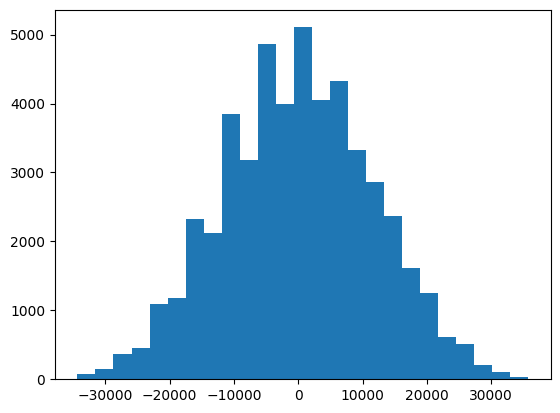

In [26]:
trials=50000

distro = [dis_field_instance( (0,0) ) for _ in range(trials)]

plt.hist(
    distro,
    bins=25,
    density=False,
    label="Monte-Carlo \n Simulation",
)
plt.show()

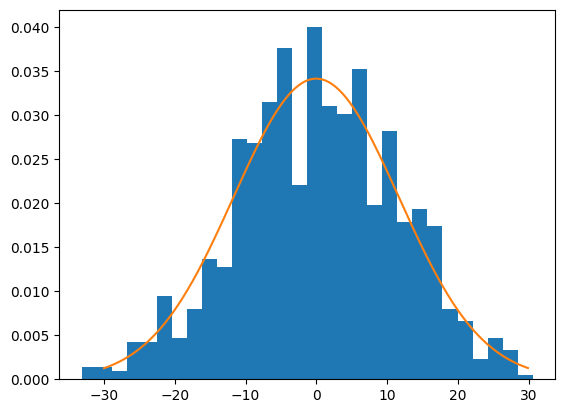

In [32]:
plt.hist(
    [y * 1e-3 for y in distro[:1000]],
    bins=30,
    density=True,
    label="Monte-Carlo \n Simulation",
)

mu=np.mean(distro)/1e3
sig=np.std(distro)/1e3

x=np.arange(-30,30,.1)
y=(1/(sig*np.sqrt(np.pi*2)))*np.exp(-.5*( (x-mu)/sig )**2)
plt.plot(x,y)
plt.show()

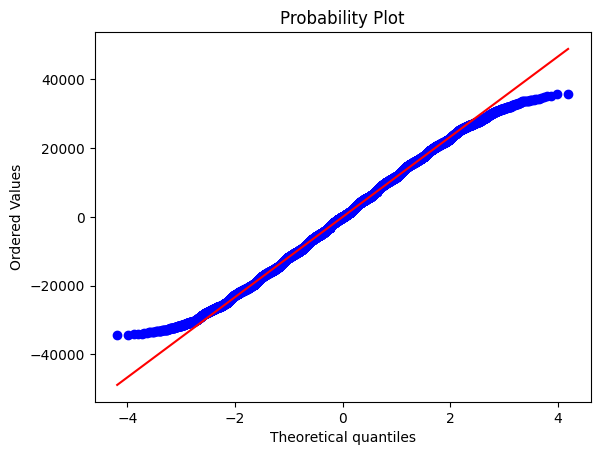

In [35]:
stats.probplot(distro, dist="norm", plot=pylab)
pylab.show()

In [41]:
std = np.std(distro)

In [36]:
#target = [(0,0),(a,a),(a,-a),(-a,a),(-a,-a),(2*a,0),(2*a,2*a),(0,2*a),(-2*a,2*a),(-2*a,0),(-2*a,-2*a),(0,-2*a),(2*a,-2*a)]

rf=8
diags = [(k*a,k*a) for k in range(-rf+1,rf,1)]
horizontals = [(k*a,0) for k in range(-rf,rf+1,2)]

In [15]:
trials=5000

distro_diag = np.array([dis_field_correlation( (0,0) , diags ) for _ in range(trials)]).T

distro_horiz = np.array([dis_field_correlation( (0,0) , horizontals ) for _ in range(trials)]).T

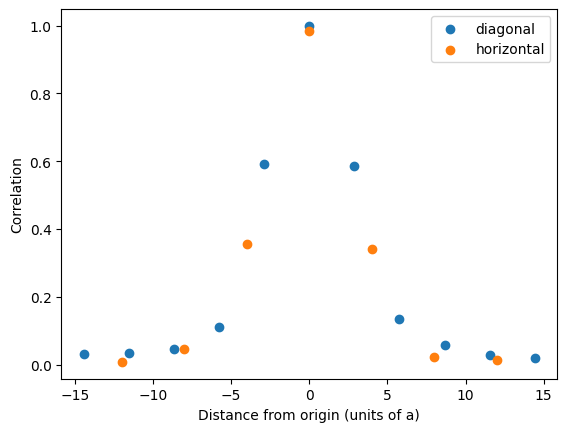

In [49]:
plt.scatter(np.sqrt(2)*np.arange(-5,6,1)*a,np.mean(distro_diag,axis=1)/std**2,label="diagonal")
plt.scatter(np.arange(-6,7,2)*2,np.mean(distro_horiz,axis=1)/std**2,label="horizontal")
plt.xlabel("Distance from origin (units of a)")
plt.ylabel("Correlation")
plt.legend()
plt.show()

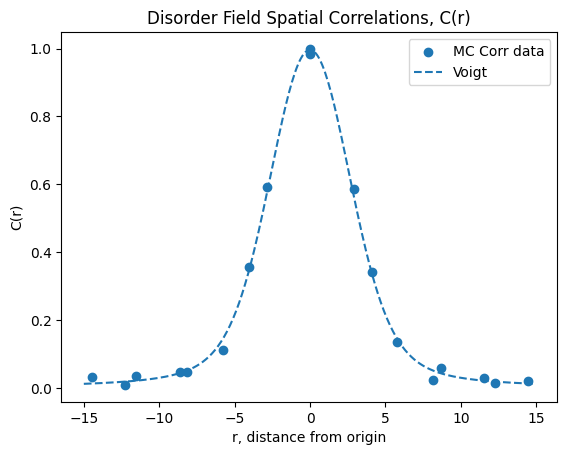

In [188]:
x = np.concatenate( (np.sqrt(2)*np.arange(-5,6,1)*a, np.arange(-6,7,2)*a))
y = np.concatenate( (np.mean(distro_diag,axis=1)/std**2, np.mean(distro_horiz,axis=1)/std**2))

plt.scatter(x, y,label="MC Corr data")
t = np.arange(-15,15,.1)
ksi=4.02
#plt.plot(t, np.exp(-(t/ksi)**2),linestyle='--',label="Gaussian")
xi=4.02/2
#plt.plot(t, xi**2/(t**2+xi**2), linestyle='--',label="Lorentzian")

plt.plot(t,7.75*sp.special.voigt_profile(t,2.25,1),linestyle='--', label="Voigt")

#R=4.02
#plt.plot(t, np.exp(-(np.abs(t)/R)), linestyle='--',label="Exponential")
plt.legend()
plt.title("Disorder Field Spatial Correlations, C(r)")
plt.ylabel("C(r)")
plt.xlabel("r, distance from origin")
plt.show()

C:\Users\awsta\AppData\Local\Temp\ipykernel_51016\3706675064.py:1: RuntimeWarning: divide by zero encountered in log
  plt.scatter(np.log(np.abs(x)), np.log(y),label="MC Corr data")


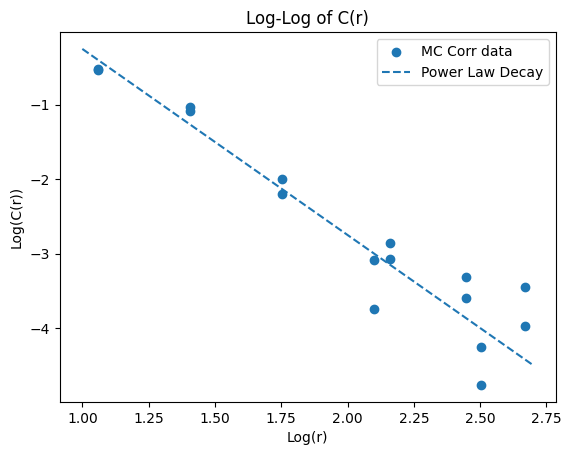

In [187]:
plt.scatter(np.log(np.abs(x)), np.log(y),label="MC Corr data")
test = np.arange(1,2.75,.1)
plt.plot(test,-2.5*test+2.25,linestyle='--',label="Power Law Decay")
plt.title("Log-Log of C(r)")
plt.ylabel("Log(C(r))")
plt.xlabel("Log(r)")
plt.legend()
plt.show()

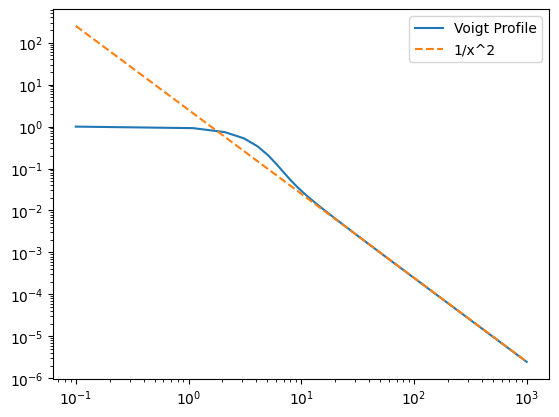

In [290]:
t = np.arange(.1,1000,1)
plt.loglog(t,7.75*sp.special.voigt_profile(t,2.25,1),linestyle='-', label="Voigt Profile")
plt.loglog(t,2.5*t**-2,linestyle='--',label="1/x^2")
plt.legend()
plt.show()


In [169]:
diag_sin_distros = {}
horiz_sin_distros = {}
trials=5000

T0 = (12*3.6/6)*us
times = [5*us, 100*us, 200*us, 300*us, 400*us, 500*us]

for time in times:
    diag_sin_distros[time] = np.array([dis_field_sin_correlation( (0,0) , diags, time) for _ in range(trials)]).T
    horiz_sin_distros[time] = np.array([dis_field_sin_correlation( (0,0) , horizontals, time) for _ in range(trials)]).T

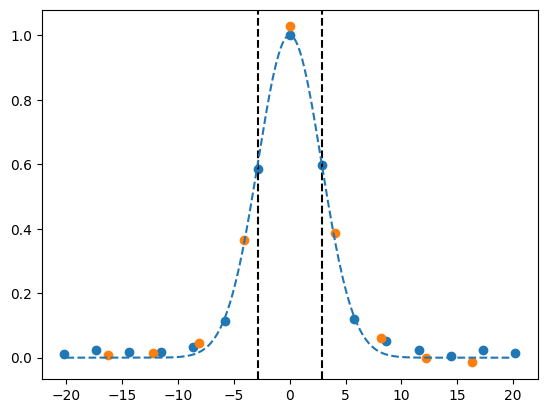

In [272]:
time = 5*us

diag_d = np.sqrt(2)*np.arange(-rf+1,rf,1)*a
diag_means=np.mean(diag_sin_distros[time], axis=1)

horiz_d = np.arange(-rf,rf+1,2)*a
horiz_means=np.mean(horiz_sin_distros[time], axis=1)
#plt.plot(t,.055*sp.special.voigt_profile(t,2.25,1),linestyle='--', label="Voigt")
plt.scatter(diag_d,diag_means/np.max(diag_means))
plt.scatter(horiz_d,horiz_means/np.max(diag_means))

plt.axvline(x = np.sqrt(2)*a,label="Nearest Neighbor Distance",linestyle='--',color='black')
plt.axvline(x = -np.sqrt(2)*a,linestyle='--',color='black')

t = np.arange(-20,20,.1)
ksi=4.02
plt.plot(t, np.exp(-(t/ksi)**2),linestyle='--',label="Gaussian")
#xi=4.02/2
#plt.plot(t, xi**2/(t**2+xi**2), linestyle='--',label="Lorentzian")

plt.show()

In [273]:
a

2.04

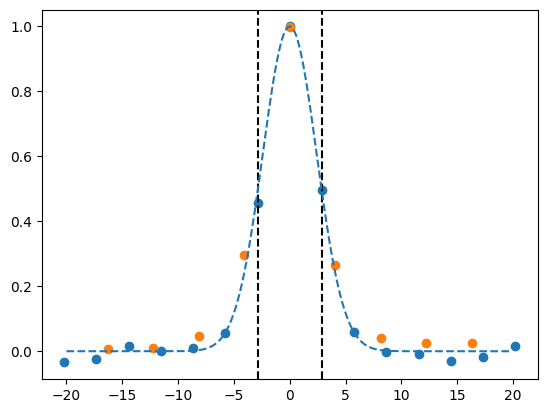

In [274]:
time = 100*us

diag_d = np.sqrt(2)*np.arange(-rf+1,rf,1)*a
diag_means=np.mean(diag_sin_distros[time], axis=1)

horiz_d = np.arange(-rf,rf+1,2)*a
horiz_means=np.mean(horiz_sin_distros[time], axis=1)
#plt.plot(t,.055*sp.special.voigt_profile(t,2.25,1),linestyle='--', label="Voigt")
plt.scatter(diag_d,diag_means/np.max(diag_means))
plt.scatter(horiz_d,horiz_means/np.max(diag_means))
plt.axvline(x = np.sqrt(2)*a,label="Nearest Neighbor Distance",linestyle='--',color='black')
plt.axvline(x = -np.sqrt(2)*a,linestyle='--',color='black')
t = np.arange(-20,20,.1)
ksi=4.02*.85
plt.plot(t, np.exp(-(t/ksi)**2),linestyle='--',label="Gaussian")
plt.show()

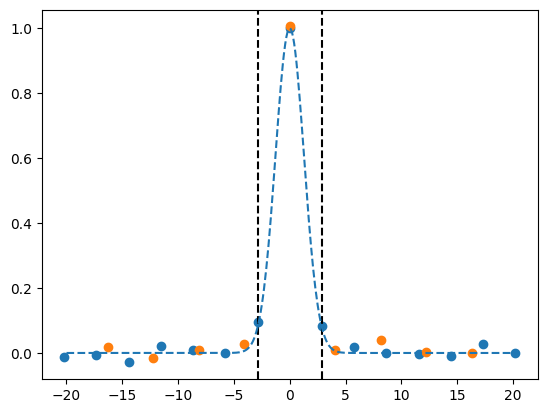

In [275]:
time = 200*us

diag_d = np.sqrt(2)*np.arange(-rf+1,rf,1)*a
diag_means=np.mean(diag_sin_distros[time], axis=1)

horiz_d = np.arange(-rf,rf+1,2)*a
horiz_means=np.mean(horiz_sin_distros[time], axis=1)
#plt.plot(t,.055*sp.special.voigt_profile(t,2.25,1),linestyle='--', label="Voigt")
plt.scatter(diag_d,diag_means/np.max(diag_means))
plt.scatter(horiz_d,horiz_means/np.max(diag_means))
plt.axvline(x = np.sqrt(2)*a,label="Nearest Neighbor Distance",linestyle='--',color='black')
plt.axvline(x = -np.sqrt(2)*a,linestyle='--',color='black')
t = np.arange(-20,20,.1)
ksi=4.02*.45
plt.plot(t, np.exp(-(t/ksi)**2),linestyle='--',label="Gaussian")
plt.show()

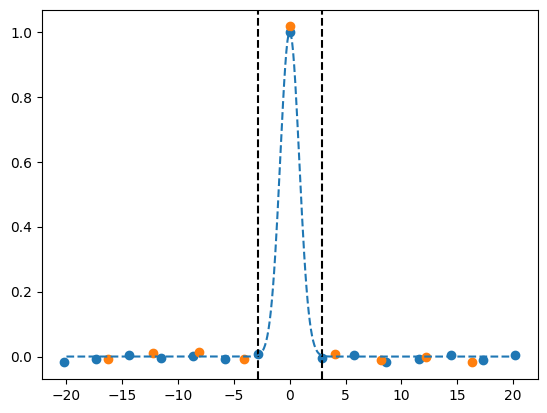

In [276]:
time= 300*us

diag_d = np.sqrt(2)*np.arange(-rf+1,rf,1)*a
diag_means=np.mean(diag_sin_distros[time], axis=1)

horiz_d = np.arange(-rf,rf+1,2)*a
horiz_means=np.mean(horiz_sin_distros[time], axis=1)

plt.scatter(diag_d,diag_means/np.max(diag_means))
plt.scatter(horiz_d,horiz_means/np.max(diag_means))
plt.axvline(x = np.sqrt(2)*a,label="Nearest Neighbor Distance",linestyle='--',color='black')
plt.axvline(x = -np.sqrt(2)*a,linestyle='--',color='black')
t = np.arange(-20,20,.1)
ksi=4.02*.3
plt.plot(t, np.exp(-(t/ksi)**2),linestyle='--',label="Gaussian")
plt.show()

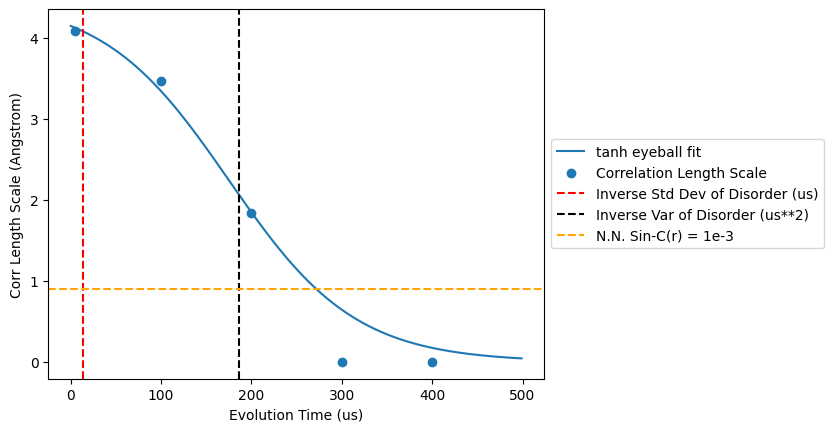

In [271]:
inv_std = (1/(2*np.pi*std))/us
t = np.arange(0,500,1)
t0=175
w=140
plt.plot(t, 1.1*a*(np.tanh(-(t-t0)/w)+1),label="tanh eyeball fit")
evo_time = [5,100,200,300, 400]
loc_len = [2*a, 2*.85*a, 2*.45*a, 0, 0]
plt.scatter(evo_time,loc_len, label="Correlation Length Scale")
plt.axvline(x = inv_std,label="Inverse Std Dev of Disorder (us)",linestyle='--',color='red')
plt.axvline(x = inv_std**2,label="Inverse Var of Disorder (us**2)",linestyle='--',color='black')
plt.axhline(y=2*a/(3*np.sqrt(np.log(10))),color='orange',linestyle='--', label="N.N. Sin-C(r) = 1e-3")
plt.xlabel("Evolution Time (us)")
plt.ylabel("Corr Length Scale (Angstrom)")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

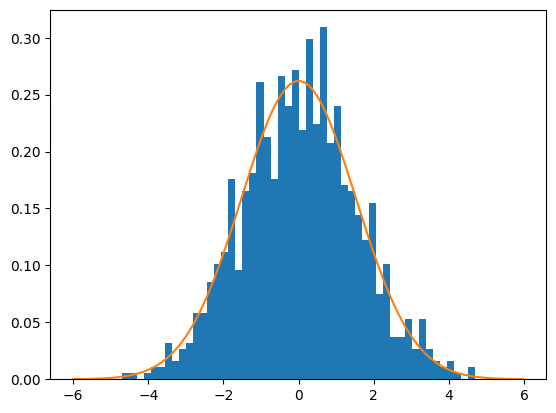

In [124]:
plt.hist(
    [y * 1e-3 for y in distro[:1000]],
    bins=50,
    density=True,
    label="Monte-Carlo \n Simulation",
)

mu=np.mean(distro)/1e3
sig=np.std(distro)/1e3

x=np.arange(-6,6,.01)
y=(1/(sig*np.sqrt(np.pi*2)))*np.exp(-.5*( (x-mu)/sig )**2)
plt.plot(x,y)
plt.show()

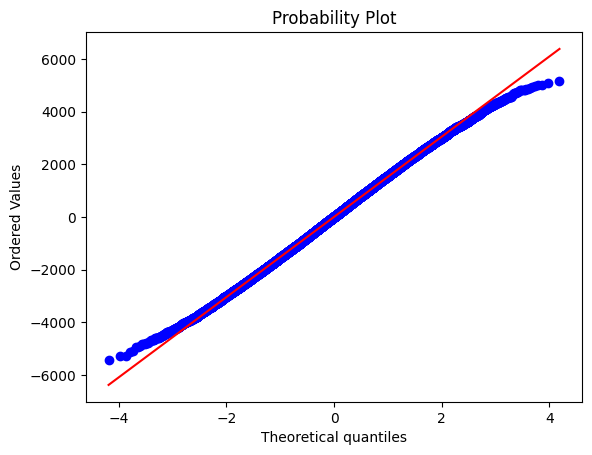

In [97]:

stats.probplot(distro, dist="norm", plot=pylab)
pylab.show()


In [123]:
from scipy.stats import shapiro
# normality test
stat, p = shapiro(distro[:1000])
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret results
alpha = 0.05
if p > alpha:
    print('Sample looks Gaussian (fail to reject H0)')
else:
    print('Sample does not look Gaussian (reject H0)')

Statistics=0.999, p=0.943
Sample looks Gaussian (fail to reject H0)


In [126]:
shapiro(distro[:1000]).statistic

0.9991611401359665

In [96]:
def distro_calc(idx1,idx2,trials):
    return [mean_field_instance(idx1,idx2) for _ in range(trials)]

vals = {}

for i in range(n_atoms):
    for j in range(i):
        vals[(i,j)] = [mean_field_instance(i,j) for _ in range(trials)]

In [112]:
means = [np.mean(distro) * 1e-3 for distro in vals.values()]
stds = [np.std(distro) * 1e-3 for distro in vals.values()]

In [165]:
shapiro_tests = [shapiro(distro[:1000]).pvalue for distro in vals.values()]

In [178]:
bad_indices = [i for i in range(len(shapiro_tests)) if shapiro_tests[i] < .05]
len(bad_indices)

253

In [182]:
n_atoms*n_atoms/2

512.0

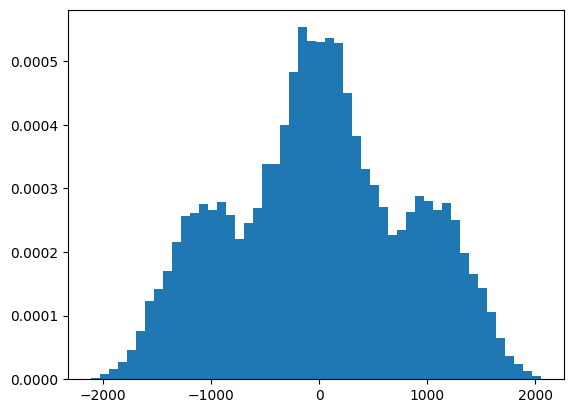

In [195]:
plt.hist(
    list(vals.values())[bad_indices[15]],
    bins=50,
    density=True,
    label="Monte-Carlo \n Simulation",
)

mu=np.mean(distro)
sig=np.std(distro)

#x=np.arange(-6,6,.01)
#y=(1/(sig*np.sqrt(np.pi*2)))*np.exp(-.5*( (x-mu)/sig )**2)
#plt.plot(x,y)
plt.show()

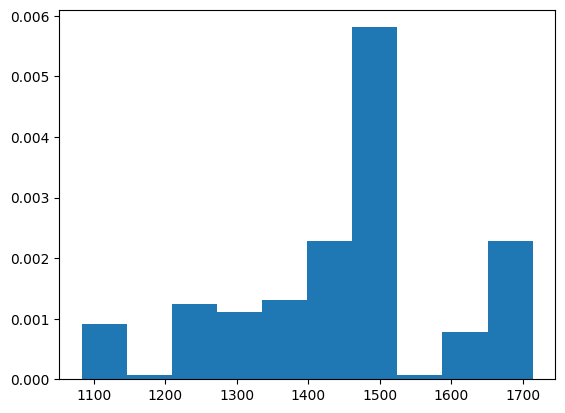

In [201]:
good_vars = []
for distro in vals.values():
    if shapiro(distro[:1000]).pvalue > 0.05:
        good_vars.append(np.std(distro))

plt.hist(
    good_vars,
    bins=10,
    density=True,
    label="Monte-Carlo \n Simulation",
)
plt.show()

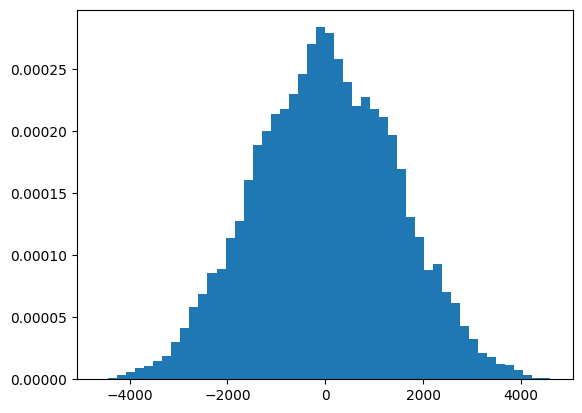

602.0583881042446

In [207]:
plt.hist(
    list(vals.values())[13],
    bins=50,
    density=True,
    label="Monte-Carlo \n Simulation",
)

mu=np.mean(distro)
sig=np.std(distro)

#x=np.arange(-6,6,.01)
#y=(1/(sig*np.sqrt(np.pi*2)))*np.exp(-.5*( (x-mu)/sig )**2)
#plt.plot(x,y)
plt.show()
sig

In [208]:
len(good_vars)

243

In [209]:
243+253

496